# Load Data from GitHub

In [ ]:
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
!sudo apt-get install git-lfs
!git lfs install

Detected operating system as Ubuntu/jammy.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Detected apt version as 2.4.13
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... Packagecloud gpg key imported to /etc/apt/keyrings/github_git-lfs-archive-keyring.gpg
done.
Running apt-get update... done.

The repository is setup! You can now install packages.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following packages will be upgraded:
  git-lfs
1 upgraded, 0 newly installed, 0 to remove and 59 not upgraded.
Need to get 7,420 kB of archives.
After this operation, 6,051 kB of additional disk space will be used.
Get:1 https://packagecloud.io/github/git-lfs/ubuntu jammy/main amd64 git-lfs amd64 3.5.1 [7,420 kB]
Fetched 7,420 kB in 1s (14.8 MB/s)
debconf: unable to initialize frontend: Dialog
debco

In [ ]:
#Importing Data
!git clone https://github.com/jinnovation/rainy-image-dataset.git
!git lfs pull

Cloning into 'rainy-image-dataset'...
remote: Enumerating objects: 15049, done.
remote: Total 15049 (delta 0), reused 0 (delta 0), pack-reused 15049 (from 1)
Receiving objects: 100% (15049/15049), 2.06 MiB | 10.52 MiB/s, done.
Resolving deltas: 100% (19/19), done.
Updating files: 100% (15005/15005), done.
Filtering content: 100% (15000/15000), 856.98 MiB | 5.64 MiB/s, done.
Not in a Git repository.


In [ ]:
!ls rainy-image-dataset

'ground truth'	'rainy image'   README.org   requirements.txt   setup.cfg   tfrecord.py


# Model Training

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

In [ ]:
IMG_HEIGHT = 256
IMG_WIDTH = 256

SAMPLE_SIZE = 14000
BUFFER_SIZE = 1000

EPOCHS = 10
BATCH_SIZE = 16

STEPS_PER_EPOCH = SAMPLE_SIZE // BATCH_SIZE

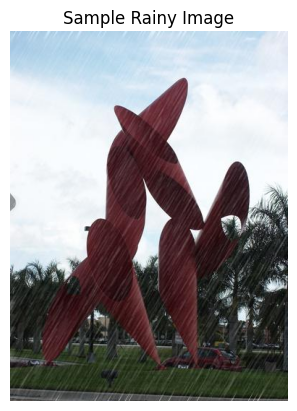

In [ ]:
rainy_image_dir = 'rainy-image-dataset/rainy image'
ground_truth_dir = 'rainy-image-dataset/ground truth'

rainy_images = os.listdir(rainy_image_dir)
ground_truth_images = os.listdir(ground_truth_dir)

sample_image_path = os.path.join(rainy_image_dir, rainy_images[random.randint(1,999)])
image = Image.open(sample_image_path)

plt.imshow(image)
plt.title('Sample Rainy Image')
plt.axis('off')
plt.show()

In [ ]:
#Preprocessing
def load_and_preprocess_rainy_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = tf.cast(image, tf.float32) / 255.0
    return image

In [ ]:
ground_truth_paths = sorted([os.path.join(ground_truth_dir, img) for img in os.listdir(ground_truth_dir)])

rainy_image_pairs = []
for gt_path in ground_truth_paths:
    base_name = os.path.splitext(os.path.basename(gt_path))[0]
    rainy_images = sorted([os.path.join(rainy_image_dir, img) for img in os.listdir(rainy_image_dir) if img.startswith(f"{base_name}_")])

    for rainy_image in rainy_images:
      rainy_image_pairs.append((gt_path, rainy_image))

print("Number of Data Pairs: ", len(rainy_image_pairs))

Number of Data Pairs:  14000


In [ ]:
#Data Generation
def create_tf_dataset(generator, sample_size = SAMPLE_SIZE):
    def data_generator():

        for index in range(len(generator)):
            gt_path, rainy_image_path = generator[index]
            gt_image = load_and_preprocess_rainy_image(gt_path)
            rainy_image = load_and_preprocess_rainy_image(rainy_image_path)
            yield rainy_image, gt_image

    tf_dataset = tf.data.Dataset.from_generator(
        data_generator,
        output_signature=(
            tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32)
        )
    )
    tf_dataset = tf_dataset.shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
    return tf_dataset

In [ ]:
tf_dataset = create_tf_dataset(rainy_image_pairs)
tf_dataset = tf_dataset.repeat()

In [ ]:
def custom_ssim_metric(y_true, y_pred):
    ssim_value = tf.image.ssim(y_true, y_pred, max_val=1.0)
    return tf.reduce_mean(ssim_value)

In [ ]:
#ResNet Model
def residual_block(x, filters):
    shortcut = x
    x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same')(x)

    if shortcut.shape[-1] != filters:
        shortcut = tf.keras.layers.Conv2D(filters, (1, 1), padding='same')(shortcut)

    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def resnet_deraining_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(64, (7, 7), padding='same', activation='relu')(inputs)

    for _ in range(3):
        x = residual_block(x, 64)

    for _ in range(3):
        x = residual_block(x, 128)

    for _ in range(3):
        x = residual_block(x, 256)

    x = tf.keras.layers.Conv2D(3, (1, 1), padding='same')(x)

    model = tf.keras.Model(inputs=[inputs], outputs=[x])
    return model

model = resnet_deraining_model((IMG_HEIGHT, IMG_WIDTH, 3))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='mean_squared_error',
              metrics=['mae', custom_ssim_metric])

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_43 (Conv2D)        │ (None, 256, 256, 64)   │          9,472 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_44 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ conv2d_43[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_45 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ conv2d_44[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_17 (Add)              │ (None, 256, 256, 64)   │              0 │ conv2d_45[0][0],       │
│                           │                        │                │ conv2d_43[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_9 (Activation) │ (None, 256, 256, 64)   │              0 │ add_17[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_46 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ activation_9[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_47 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ conv2d_46[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_18 (Add)              │ (None, 256, 256, 64)   │              0 │ conv2d_47[0][0],       │
│                           │                        │                │ activation_9[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_10             │ (None, 256, 256, 64)   │              0 │ add_18[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_48 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ activation_10[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_49 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ conv2d_48[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_19 (Add)              │ (None, 256, 256, 64)   │              0 │ conv2d_49[0][0],       │
│                           │                        │                │ activation_10[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_11             │ (None, 256, 256, 64)   │              0 │ add_19[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_50 (Conv2D)        │ (None, 256, 256, 128)  │         73,856 │ activation_11[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_51 (Conv2D)        │ (None, 256, 256, 128)  │        147,584 │ conv2d_50[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_52 (Conv2D)   

 Total params: 4,330,499 (16.52 MB)

 Trainable params: 4,330,499 (16.52 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(tf_dataset, epochs=EPOCHS, steps_per_epoch = STEPS_PER_EPOCH)

Epoch 1/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 466s 512ms/step - custom_ssim_metric: 0.7361 - loss: 0.0087 - mae: 0.0569
Epoch 2/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 459s 512ms/step - custom_ssim_metric: 0.8467 - loss: 0.0023 - mae: 0.0344
Epoch 3/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 459s 512ms/step - custom_ssim_metric: 0.8609 - loss: 0.0020 - mae: 0.0316
Epoch 4/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 459s 512ms/step - custom_ssim_metric: 0.8696 - loss: 0.0018 - mae: 0.0304
Epoch 5/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 459s 512ms/step - custom_ssim_metric: 0.8772 - loss: 0.0016 - mae: 0.0281
Epoch 6/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 459s 512ms/step - custom_ssim_metric: 0.8816 - loss: 0.0016 - mae: 0.0275
Epoch 7/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 458s 512ms/step - custom_ssim_metric: 0.8855 - loss: 0.0015 - mae: 0.0265
Epoch 8/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 458s 512ms/step - custom_ssim_metric: 0.8889 - loss: 0.0014 - mae: 0.0259
Epoch 9/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 458s 512ms/step - custom_ssim_metric: 0.8919 - l

In [ ]:
#Save Model
from google.colab import drive
drive.mount('/content/drive')

model.save('/content/drive/MyDrive/ip_resnet.keras')

Mounted at /content/drive


# Model Evaluation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model = tf.keras.models.load_model('/content/drive/MyDrive/ip_resnet.keras', custom_objects={'custom_ssim_metric': custom_ssim_metric})

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def calculate_psnr_ssim(predicted_image, ground_truth_image):
    if isinstance(ground_truth_image, tf.Tensor):
        ground_truth_image = ground_truth_image.numpy()

    if isinstance(predicted_image, tf.Tensor):
        predicted_image = predicted_image.numpy()

    if ground_truth_image.dtype != predicted_image.dtype:
        ground_truth_image = ground_truth_image.astype(np.float32) / 255 if ground_truth_image.max() > 1 else ground_truth_image
        predicted_image = predicted_image.astype(np.float32) / 255 if predicted_image.max() > 1 else predicted_image

    if predicted_image.shape != ground_truth_image.shape:
        print("Error: Images have different shapes.")
        return None, None

    psnr_value = psnr(ground_truth_image, predicted_image)
    ssim_value = ssim(ground_truth_image, predicted_image, data_range=ground_truth_image.max() - ground_truth_image.min(), channel_axis=2)

    return psnr_value, ssim_value

In [ ]:
#Printing Results
def output_fn(particular_rainy_img, particular_gt_img):
  image_path = rainy_image_dir + particular_rainy_img
  original_image = load_and_preprocess_rainy_image(image_path)
  original_unexpanded_img = original_image
  original_image = tf.expand_dims(original_image, axis=0)

  ground_truth_path = ground_truth_dir + particular_gt_img
  ground_truth_image = load_and_preprocess_rainy_image(ground_truth_path)

  predicted_image = model.predict(original_image)
  predicted_image = np.squeeze(predicted_image)
  predicted_image = (predicted_image * 255).astype(np.uint8)

  psnr_value, ssim_value = calculate_psnr_ssim(predicted_image, ground_truth_image)

  fig, axes = plt.subplots(1, 3, figsize=(15, 5))

  axes[0].imshow(original_unexpanded_img)
  axes[0].set_title('Original Rainy Image')
  axes[0].axis('off')

  axes[1].imshow(predicted_image)
  axes[1].set_title(f'Predicted Clean Image; PSNR = {psnr_value:.2f}; SSIM = {ssim_value:.2f}')
  axes[1].axis('off')

  axes[2].imshow(ground_truth_image)
  axes[2].set_title('Ground Truth Image')
  axes[2].axis('off')

  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


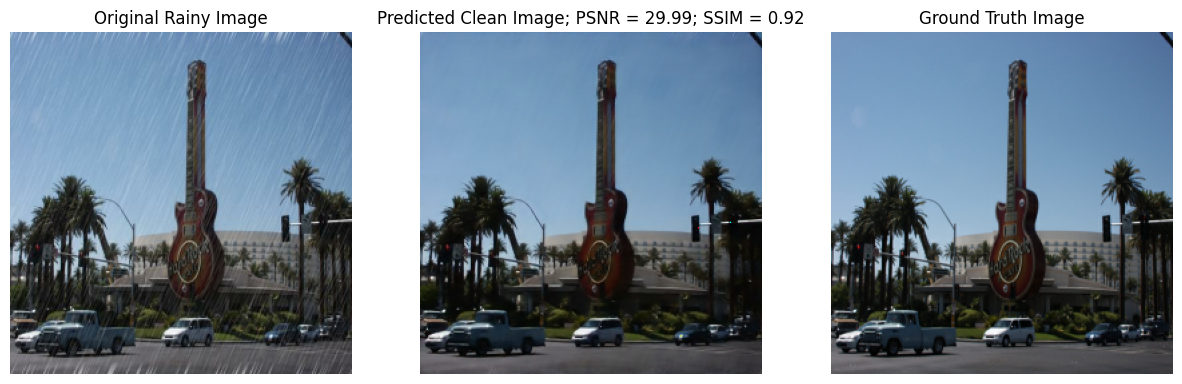

In [ ]:
particular_rainy_img = '/504_2.jpg'
particular_gt_img = '/504.jpg'

output_fn(particular_rainy_img, particular_gt_img)

# Old Code + Data Log

In [ ]:
#Dataset Generation
def create_tf_dataset(generator, sample_size = SAMPLE_SIZE):
    def data_generator():
        selected_indices = np.random.choice(len(generator), size=sample_size, replace=False)

        for index in selected_indices:
            gt_path, rainy_images = generator[index]
            gt_image = load_and_preprocess_rainy_image(gt_path)
            for rainy_image_path in rainy_images:
                rainy_image = load_and_preprocess_rainy_image(rainy_image_path)
                yield rainy_image, gt_image

    tf_dataset = tf.data.Dataset.from_generator(
        data_generator,
        output_signature=(
            tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32)
        )
    )
    tf_dataset = tf_dataset.shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
    return tf_dataset

In [ ]:
def residual_block(x, filters, downsample=False):
    shortcut = x

    x = tf.keras.layers.Conv2D(filters, (3, 3), strides=(2, 2) if downsample else (1, 1), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if downsample or shortcut.shape[-1] != filters:
        shortcut = tf.keras.layers.Conv2D(filters, (1, 1), strides=(2, 2) if downsample else (1, 1), padding='same')(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.ReLU()(x)
    return x

def resnet18_deraining_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(64, (7, 7), strides=(1, 1), padding='same', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, downsample=True)
    x = residual_block(x, 128)

    x = residual_block(x, 256, downsample=True)
    x = residual_block(x, 256)

    x = residual_block(x, 512, downsample=True)
    x = residual_block(x, 512)

    x = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x)

    x = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same')(x)

    x = tf.keras.layers.Conv2D(3, (1, 1), padding='same', activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[inputs], outputs=[x])
    return model